# Multi-label prediction with Planet Amazon dataset

The FastAI library allows us to build models using only a few lines of code. Furthermore it implements some of the newest state-of-the-art technics taken from research papers that allow you to get state-of-the-art results on almost any type of problem.

In this notebook we will go over how to create a cnn for multi-label image classification.

If you want more details you can check the corresponding article [here](https://towardsdatascience.com/fastai-multi-label-image-classification-8034be646e95).

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *

In [3]:
path = Path('/media/gilbert/948A92E98A92C760/Local_Programming/Datasets/Other/Planet Understanding the Amazon from Space')

## Get data

In [4]:
df = pd.read_csv(path/'train_v2.csv')
df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [5]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [6]:
np.random.seed(42)
src = (ImageItemList.from_csv(path, 'train_v2.csv', folder='train-jpg', suffix='.jpg')
       .random_split_by_pct(0.2)
       .label_from_df(label_delim=' '))

In [7]:
data = (src.transform(tfms, size=128)
        .databunch(bs=64).normalize(imagenet_stats))

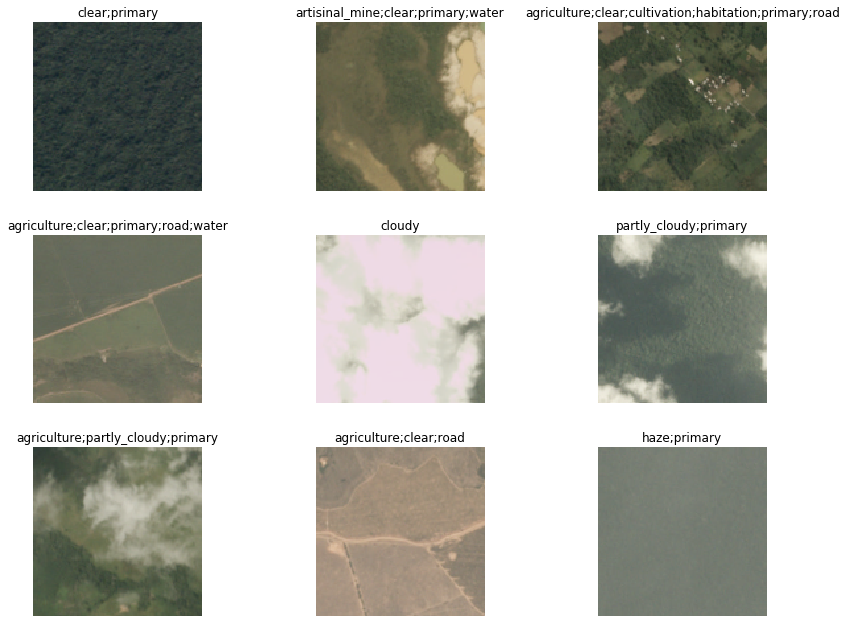

In [8]:
data.show_batch(rows=3, figsize=(12, 9))

## Training

In [9]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)
learn = create_cnn(data, models.resnet50, metrics=[acc_02, f_score])

In [10]:
learn

Learner(data=ImageDataBunch;

Train: LabelList
y: MultiCategoryList (32384 items)
[MultiCategory haze;primary, MultiCategory clear;primary, MultiCategory clear;primary, MultiCategory haze;primary;water, MultiCategory agriculture;clear;cultivation;primary;water]...
Path: /media/gilbert/948A92E98A92C760/Local_Programming/Datasets/Other/Planet Understanding the Amazon from Space
x: ImageItemList (32384 items)
[Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256)]...
Path: /media/gilbert/948A92E98A92C760/Local_Programming/Datasets/Other/Planet Understanding the Amazon from Space;

Valid: LabelList
y: MultiCategoryList (8095 items)
[MultiCategory clear;primary;road, MultiCategory clear;primary;water, MultiCategory clear;conventional_mine;habitation;primary;road;water, MultiCategory cloudy, MultiCategory agriculture;clear;cultivation;cultivation;habitation;primary;road;water]...
Path: /media/gilbert/948A92E98A92C760/Local_Programming/Dataset

In [11]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


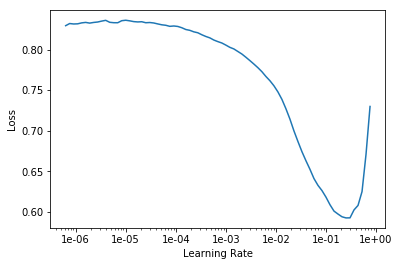

In [12]:
learn.recorder.plot()

In [13]:
lr = 0.01
learn.fit_one_cycle(4, lr)

epoch,train_loss,valid_loss,accuracy_thresh,fbeta
1,0.124416,0.106247,0.941184,0.906591
2,0.111326,0.096467,0.950471,0.915221
3,0.100183,0.089773,0.952789,0.922327
4,0.094331,0.088064,0.955848,0.923537


In [14]:
learn.save('planet-amazon-stage-1')

In [15]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


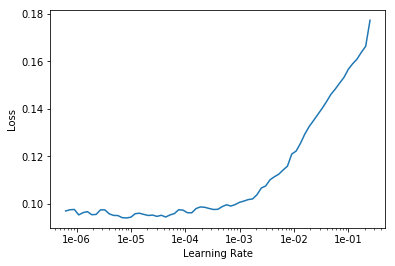

In [16]:
learn.lr_find()
learn.recorder.plot()

In [17]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta
1,0.096554,0.091000,0.951967,0.924013
2,0.096375,0.092748,0.951016,0.917588
3,0.091672,0.086210,0.957875,0.926523
4,0.085128,0.083991,0.956800,0.927893
5,0.080853,0.083033,0.958965,0.928849


In [18]:
learn.save('planet-amazon-stage-2')

In [19]:
# switch resolution
data = (src.transform(tfms, size=256)
        .databunch(bs=16).normalize(imagenet_stats))
learn.data = data

In [20]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


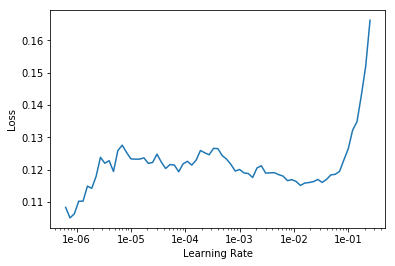

In [21]:
learn.lr_find()
learn.recorder.plot()

In [22]:
lr=1e-2/2
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta
1,0.105285,0.089191,0.956320,0.923166
2,0.101119,0.093919,0.960643,0.923546
3,0.093579,1.170965,0.955913,0.923894
4,0.091962,1.543742,0.956531,0.922733
5,0.093357,0.508340,0.957206,0.924794


In [23]:
learn.save('planet-amazon-stage-3')

In [24]:
learn.unfreeze()
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta
1,0.096079,2.023037,0.952934,0.920048
2,0.095694,0.543676,0.958042,0.921272
3,0.094014,0.485411,0.954562,0.923282
4,0.087650,0.504817,0.960280,0.927146
5,0.083933,0.924733,0.956320,0.924387


In [27]:
learn.save('planet-amazon-stage-4')

In [28]:
learn.export()

## Submitting to Kaggle

In [32]:
dataframes = []

for directory in ('test-jpg', 'test-jpg-additional'):
    test = ImageItemList.from_folder(path/directory)
    learn = load_learner(path, test=test)
    preds, _ = learn.get_preds(ds_type=DatasetType.Test)
    thresh = 0.2
    labelled_preds = [' '.join([learn.data.classes[i] for i,p in enumerate(pred) if p > thresh]) for pred in preds]
    fnames = [f.name[:-4] for f in learn.data.test_ds.items]
    df = pd.DataFrame({'image_name':fnames, 'tags':labelled_preds}, columns=['image_name', 'tags'])
    dataframes.append(df)

In [33]:
df = pd.concat(dataframes)
df.to_csv(path/'submission.csv', index=False)
df.head()

,image_name,tags
0,test_24526,clear primary
1,test_24527,clear primary
2,test_24528,partly_cloudy primary
3,test_24529,agriculture clear habitation primary road
4,test_2453,haze partly_cloudy primary water


In [34]:
len(df)

61191

In [ ]:
! kaggle competitions submit planet-understanding-the-amazon-from-space -f {path/'submission.csv'} -m "My submission"